# House Pricing - Advanced Linear Regression (Lasso & Ridge)

#### Problem Statement


A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

    Which variables are significant in predicting the price of a house, and

    How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

 

#### Business Goal 

 

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

In [1]:
# Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler

import os
import warnings
warnings.filterwarnings('ignore')

### Read and Understand Data

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.shape

(1460, 81)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Check the missing data

In [5]:
mis_val = data.isnull().sum()
mis_val_percentage = 100*mis_val/len(data)
missing_val = pd.concat([mis_val,mis_val_percentage],axis =1)
missing_val = missing_val.rename(columns = {0:'Missing Values',1:'% of Total Values'})
missing_val = missing_val.loc[missing_val['Missing Values']>0]
missing_val = missing_val.sort_values('Missing Values',ascending = False)
missing_val.head(30)

,Missing Values,% of Total Values
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


Upon analysis it was found not all missing values are really missing one's. Some of them have a meaning and hence should be carefully treated.

These columns donot have null values rather NA. Hence should be updated accordingly.

In [6]:
updateMissingCol=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']

In [7]:
for col in updateMissingCol:
    data[col].fillna(value='None',inplace=True)

 Missing value imputation to be done only for below columns.
['MasVnrArea', 'MasVnrType', 'Electrical','LotFrontage','GarageYrBlt']

In [8]:
data['Electrical'].fillna(value=data['Electrical'].mode()[0],inplace=True)

In [9]:
data['MasVnrType'].fillna(value=data['MasVnrType'].mode()[0],inplace=True)

In [10]:
data['MasVnrArea'].fillna(value=data['MasVnrArea'].median(),inplace=True)

In [11]:
data['LotFrontage'].fillna(value=data['LotFrontage'].median(),inplace=True)

GarageYrBlt missing values means absense of Garage. As in coming steps we are going to calculate age (derived column) 
and drop the original GarageBuilt column we will impute now it as YearSold+1. So that the age column will come as -1.

In [12]:
data['GarageYrBlt'].fillna(value=data['YrSold'],inplace=True)

Columns which have over 85% same value, wont contribute to the model hence can be dropped.

In [13]:
for col in data.columns:
    if round(data[col].value_counts(normalize=True).max(),2) > 0.85 :
        print("Removing Column : " + col + " with percentage : " + str(round(data[col].value_counts(normalize=True).max(),2)*100))
        data = data.drop(col,axis=1)

Removing Column : Street with percentage : 100.0
Removing Column : Alley with percentage : 94.0
Removing Column : LandContour with percentage : 90.0
Removing Column : Utilities with percentage : 100.0
Removing Column : LandSlope with percentage : 95.0
Removing Column : Condition1 with percentage : 86.0
Removing Column : Condition2 with percentage : 99.0
Removing Column : RoofMatl with percentage : 98.0
Removing Column : ExterCond with percentage : 88.0
Removing Column : BsmtCond with percentage : 90.0
Removing Column : BsmtFinType2 with percentage : 86.0
Removing Column : BsmtFinSF2 with percentage : 89.0
Removing Column : Heating with percentage : 98.0
Removing Column : CentralAir with percentage : 93.0
Removing Column : Electrical with percentage : 91.0
Removing Column : LowQualFinSF with percentage : 98.0
Removing Column : BsmtHalfBath with percentage : 94.0
Removing Column : KitchenAbvGr with percentage : 95.0
Removing Column : Functional with percentage : 93.0
Removing Column : Ga

In [14]:
# Id column has all unique values hence can be dropped.
data = data.drop('Id',axis=1)

In [15]:
# Check for duplicate data
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
data[dups]

Number of duplicate rows = 0


,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Fence,MoSold,YrSold,SaleCondition,SalePrice


In [16]:
data.shape

(1460, 50)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 50 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LotConfig      1460 non-null   object 
 6   Neighborhood   1460 non-null   object 
 7   BldgType       1460 non-null   object 
 8   HouseStyle     1460 non-null   object 
 9   OverallQual    1460 non-null   int64  
 10  OverallCond    1460 non-null   int64  
 11  YearBuilt      1460 non-null   int64  
 12  YearRemodAdd   1460 non-null   int64  
 13  RoofStyle      1460 non-null   object 
 14  Exterior1st    1460 non-null   object 
 15  Exterior2nd    1460 non-null   object 
 16  MasVnrType     1460 non-null   object 
 17  MasVnrArea     1460 non-null   float64
 18  ExterQua

### Derived Columns

Converting the Year columns(YearBuilt, YearRemodAdd, GarageYrBlt to Age(as per sold year) and drop the original 3 year columns.

In [18]:
data['Age_Built_Sold']=data['YrSold']-data['YearBuilt']
data['Age_ReBuilt_Sold']=data['YrSold']-data['YearRemodAdd']
data['Age_Garage_Sold']=(data['YrSold']-data['GarageYrBlt']).astype(int)

In [19]:
data = data.drop('GarageYrBlt',axis=1)
data = data.drop('YearBuilt',axis=1)
data = data.drop('YearRemodAdd',axis=1)

In [20]:
data['YrSold']=data['YrSold'].astype('object')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        1460 non-null   int64  
 1   MSZoning          1460 non-null   object 
 2   LotFrontage       1460 non-null   float64
 3   LotArea           1460 non-null   int64  
 4   LotShape          1460 non-null   object 
 5   LotConfig         1460 non-null   object 
 6   Neighborhood      1460 non-null   object 
 7   BldgType          1460 non-null   object 
 8   HouseStyle        1460 non-null   object 
 9   OverallQual       1460 non-null   int64  
 10  OverallCond       1460 non-null   int64  
 11  RoofStyle         1460 non-null   object 
 12  Exterior1st       1460 non-null   object 
 13  Exterior2nd       1460 non-null   object 
 14  MasVnrType        1460 non-null   object 
 15  MasVnrArea        1460 non-null   float64
 16  ExterQual         1460 non-null   object 


#### Recheck Missing Values

In [22]:
(data.isnull().sum()>0).sum()

0

### Convert number values into logical categories for EDA.

[MSSubClass,OverallQual,OverallCond,MoSold]

In [23]:
data['OverallQual'] = data['OverallQual'].map({1:'VPoor',2:'Poor', 3:'Fair',4:'BelAvg',5:'Avg',6:'AbvAvg',7:'Good',8:'VGood',9:'Exc',10:'VExc'})
data['OverallCond'] = data['OverallCond'].map({1:'VPoor',2:'Poor',3:'Fair',4:'BelAvg',5:'Avg',6:'AbvAvg',7:'Good',8:'VGood',9:'Exc',10:'VExc'})

In [24]:
data['MSSubClass'] = data['MSSubClass'].map({20:'1-STORY 1946 & NEWER',30:'1-STORY 1945 & OLDER',40:'1-STORY W/FINISHED ATTIC',45:'1-1/2 STORY-UNFINISHED',50:'1-1/2 STORY FINISHED',60:'2-STORY 1946 & NEWER',70:'2-STORY 1945 & OLDER',75:'2-1/2 STORY',80:'SPLIT OR MULTI-LEVEL',85:'SPLIT FOYER',90:'DUPLEX',120:'1-STORY PUD',150:'1-1/2 STORY PUD',160:'2-STORY PUD',180:'PUD-MULTILEVEL',190:'2 FAMILY CONVERSION'})

In [25]:
data['MoSold'] = data['MoSold'].map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

### Analysis of Target variable - SalePrice

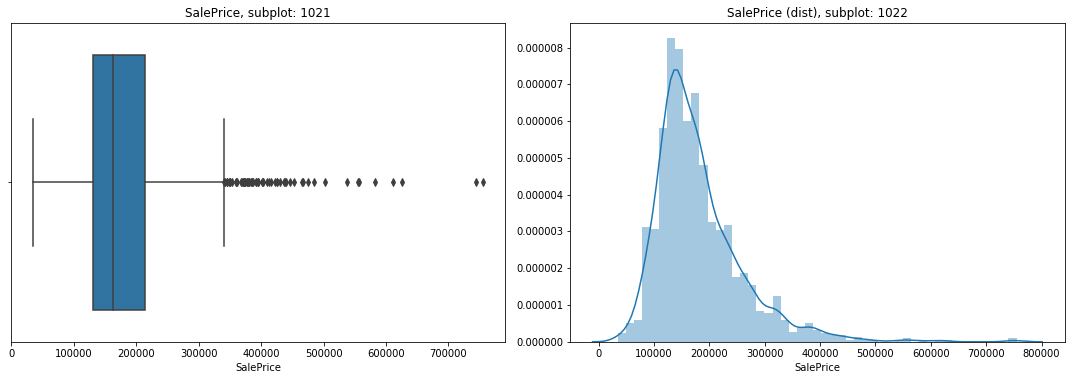

In [26]:
target_col = ['SalePrice']
a = 10  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(50,40))
fig.set_size_inches(15, 50)

for i in target_col:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.boxplot(data[i])
    c = c + 1
    
    plt.subplot(a, b, c)
    plt.title('{} (dist), subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.distplot(data[i])
    c = c + 1  

plt.tight_layout()
plt.show();

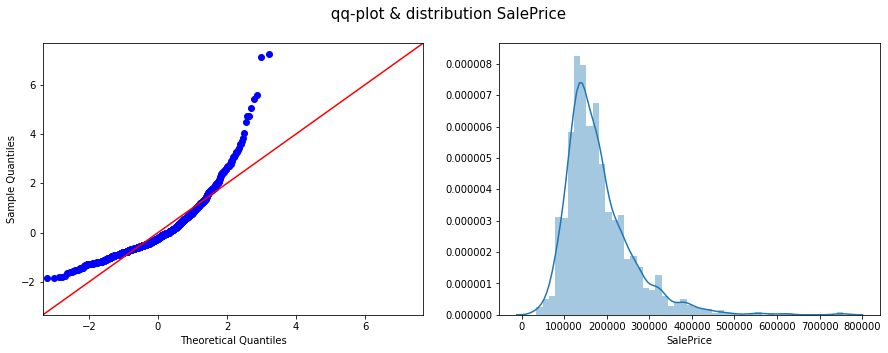

In [27]:
import statsmodels.api as sm
from scipy import stats

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(data['SalePrice'],fit=True, line="45", ax = ax[0])

sns.distplot(data['SalePrice'], kde = True, hist=True, ax = ax[1])
plt.show()

Observation - The saleprice target variable is right skewed hence we apply log transformation

In [28]:
target_col = ['SalePrice_log']
data['SalePrice_log'] = np.log(data['SalePrice'])
saleprice = data[['SalePrice']].copy()
data = data.drop('SalePrice',axis=1) # removing the orignal variable

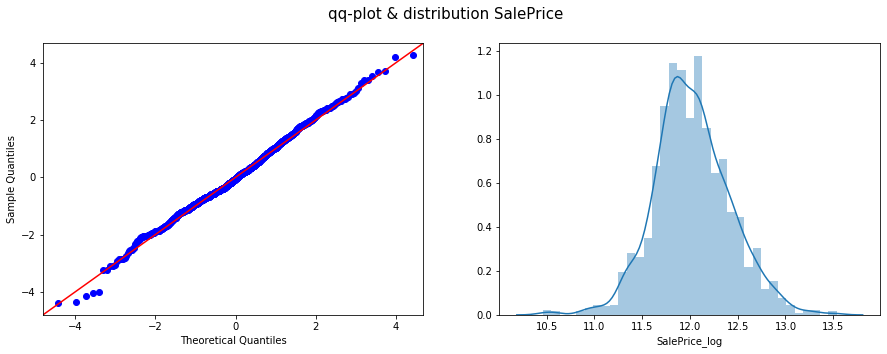

In [29]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(data['SalePrice_log'] , stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(data['SalePrice_log'] , kde = True, hist=True, ax = ax[1])
plt.show()

### Split data to numerical and categorical data

In [30]:
num_col = data.select_dtypes(include=np.number).columns.tolist()
num_col

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'Age_Built_Sold',
 'Age_ReBuilt_Sold',
 'Age_Garage_Sold',
 'SalePrice_log']

In [31]:
cat_col = list(set(data.columns)-set(num_col))
cat_col

['BsmtExposure',
 'YrSold',
 'GarageType',
 'MSZoning',
 'HouseStyle',
 'KitchenQual',
 'Neighborhood',
 'SaleCondition',
 'Exterior2nd',
 'MSSubClass',
 'Exterior1st',
 'ExterQual',
 'BldgType',
 'RoofStyle',
 'HeatingQC',
 'Fence',
 'OverallQual',
 'BsmtQual',
 'MasVnrType',
 'MoSold',
 'OverallCond',
 'FireplaceQu',
 'Foundation',
 'LotShape',
 'GarageFinish',
 'LotConfig',
 'BsmtFinType1']

In [32]:
for col in cat_col:
    data[col]=data[col].astype('object')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        1460 non-null   object 
 1   MSZoning          1460 non-null   object 
 2   LotFrontage       1460 non-null   float64
 3   LotArea           1460 non-null   int64  
 4   LotShape          1460 non-null   object 
 5   LotConfig         1460 non-null   object 
 6   Neighborhood      1460 non-null   object 
 7   BldgType          1460 non-null   object 
 8   HouseStyle        1460 non-null   object 
 9   OverallQual       1460 non-null   object 
 10  OverallCond       1460 non-null   object 
 11  RoofStyle         1460 non-null   object 
 12  Exterior1st       1460 non-null   object 
 13  Exterior2nd       1460 non-null   object 
 14  MasVnrType        1460 non-null   object 
 15  MasVnrArea        1460 non-null   float64
 16  ExterQual         1460 non-null   object 


### Analysis of Numerical Columns using Box Plots for Outliers

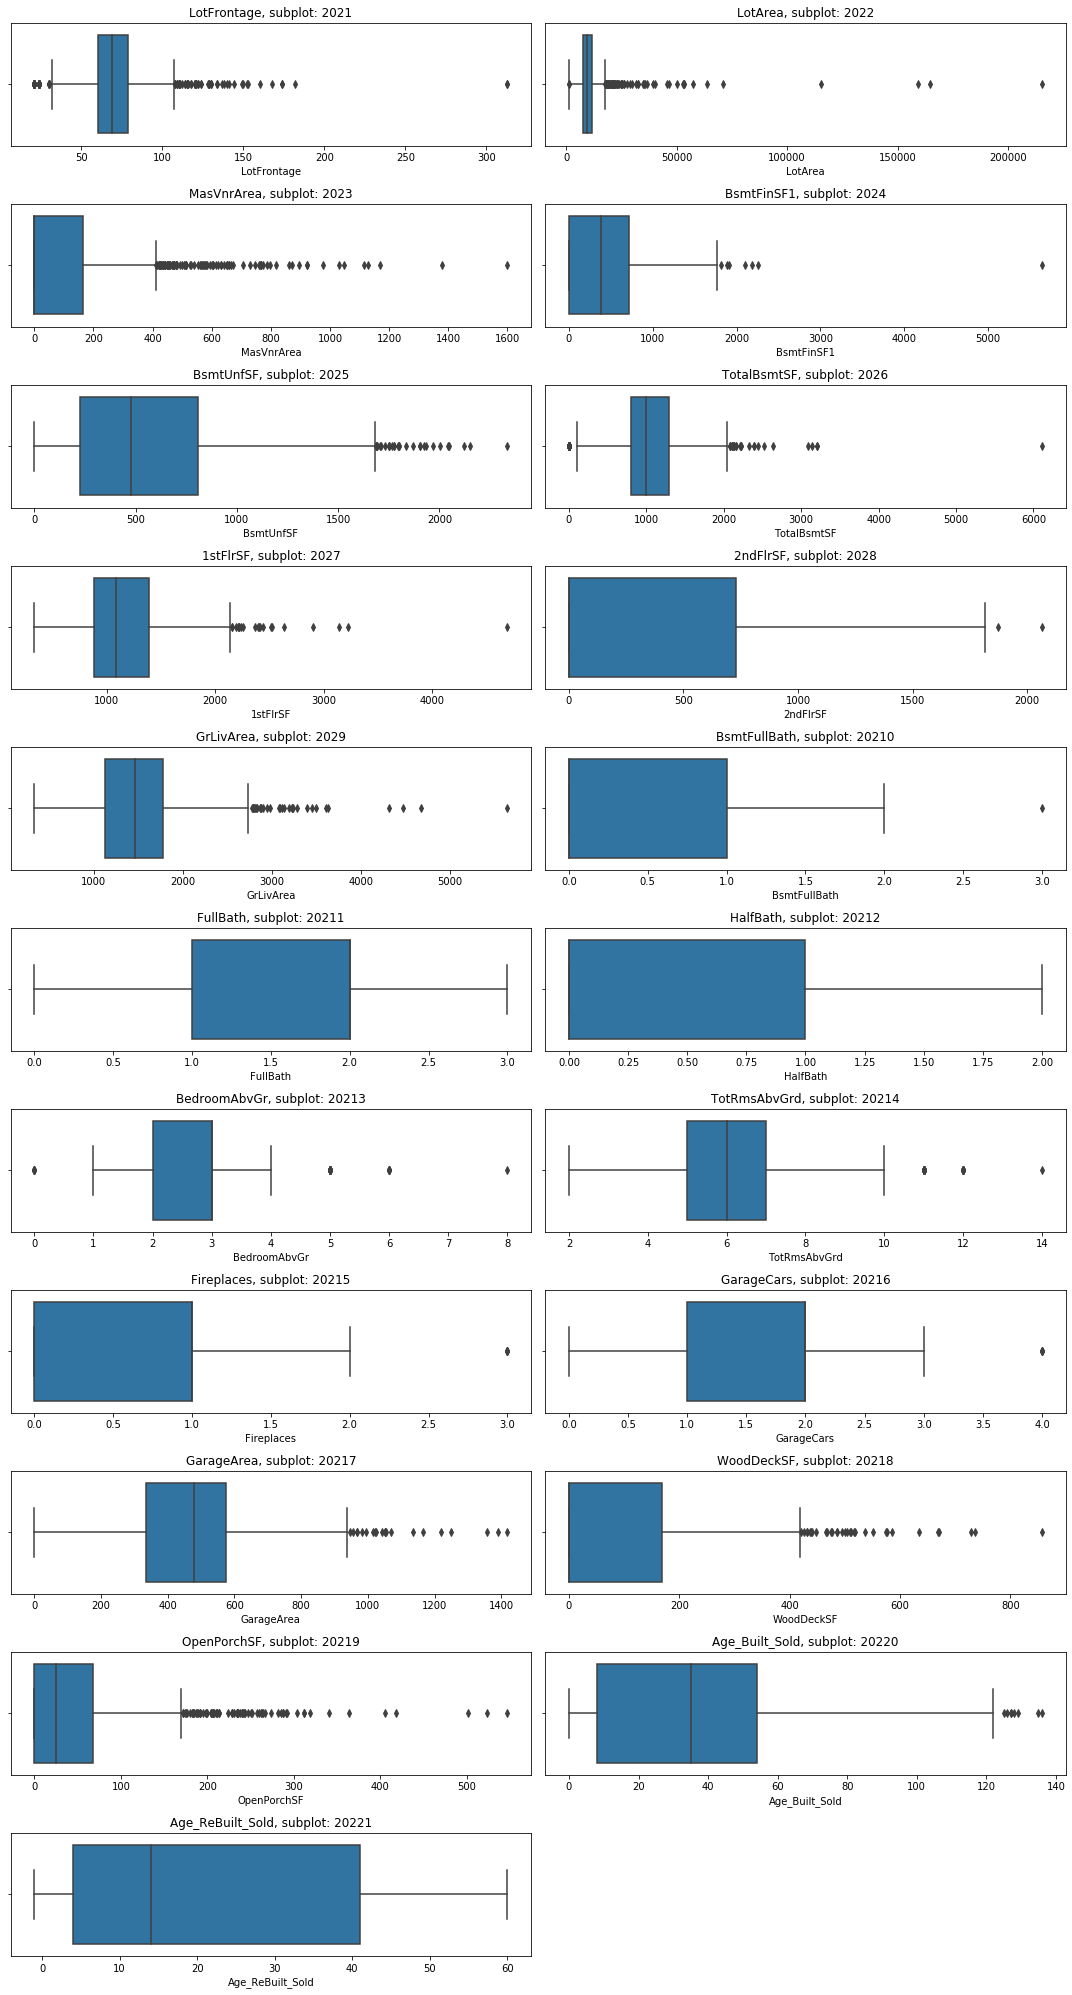

In [35]:
colList = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'Age_Built_Sold', 'Age_ReBuilt_Sold']
a = 20
b = 2
c = 1
fig = plt.figure(figsize=(50,40))
fig.set_size_inches(15, 50)
for i in colList:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.boxplot(data[i])
    c = c + 1
    plt.tight_layout()
plt.show();

### Outlier Treatment for numeric columns

In [36]:
def outlier_treatment(df,colName):
    IQR = df[colName].quantile(0.75)-df[colName].quantile(0.25)
    UF = df[colName].quantile(0.75) + (1.5*IQR)
    df.loc[df[colName] > UF,colName]=UF

In [37]:
for col in num_col:
    outlier_treatment(data,col)

### Relationship of numerical features with the target variable.

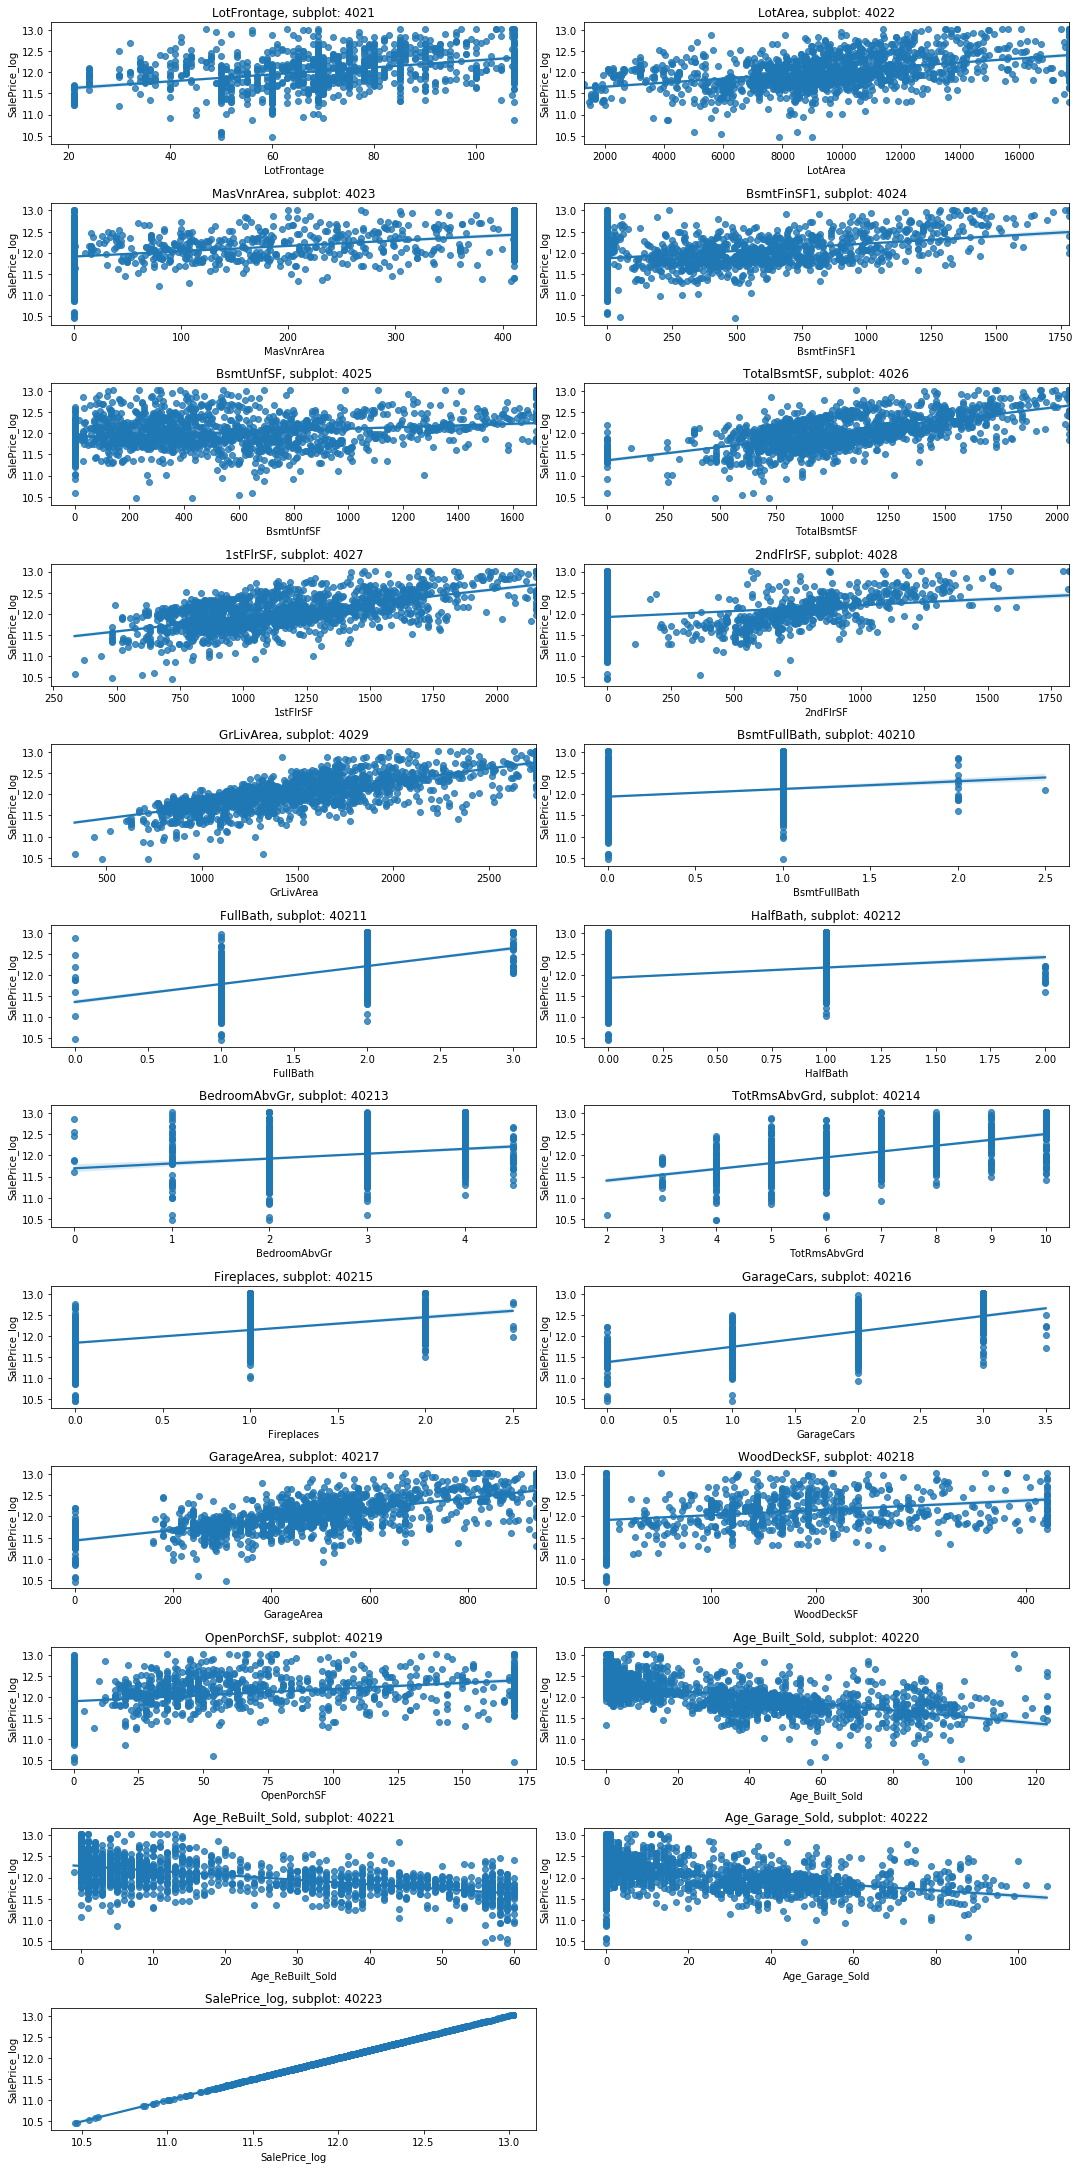

In [38]:
a = 40
b = 2
c = 1

fig = plt.figure(figsize=(50,40))
fig.set_size_inches(15, 100)

for i in num_col:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.regplot(data[i], data['SalePrice_log'])
    c = c + 1

plt.tight_layout()
plt.show();

#### Check Correlation

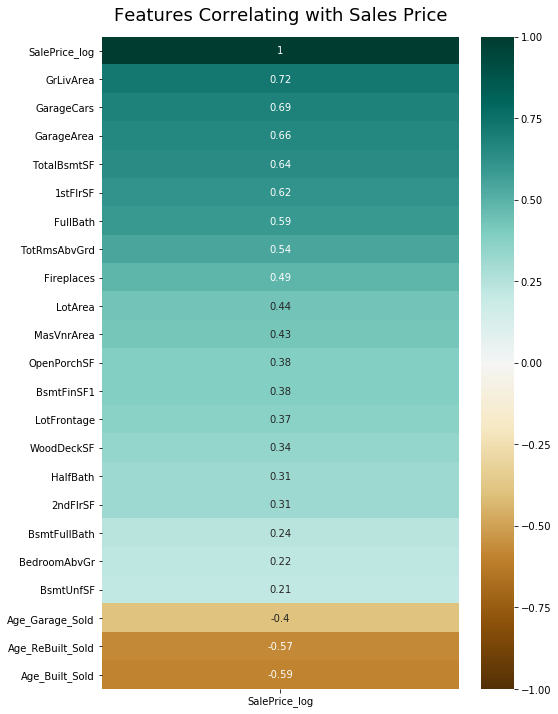

In [39]:
plt.figure(figsize=(8, 12))
heatmap_outputvar = sns.heatmap(data[num_col].corr()[['SalePrice_log']].sort_values(by='SalePrice_log', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap_outputvar.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

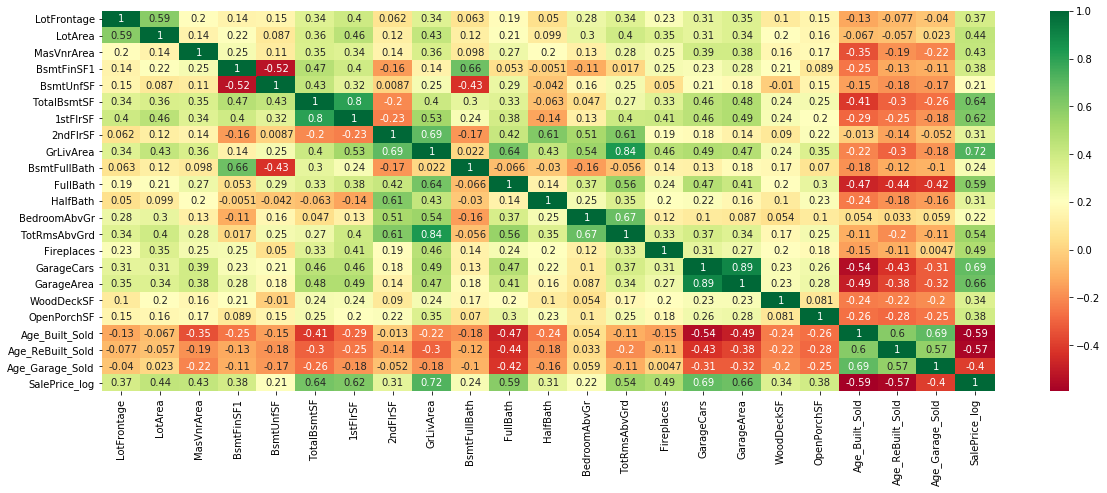

In [40]:
plt.figure(figsize=(20,7))
sns.heatmap(data[num_col].corr(),annot=True,cmap="RdYlGn")

#### Observation(Numerical Features) :

Relationship between independent variable with target variable(Sale Price)

    GrLivArea, GarageCars, GarageArea, TotalBsmntSF, 1stFLSF have high positive correlation with Sales Price and Age of house has negative correlation with Sale Price.
    
Relationship between independent variable with other independent variable(Sale Price)

    

### Relationship of Categorical Features with target variable

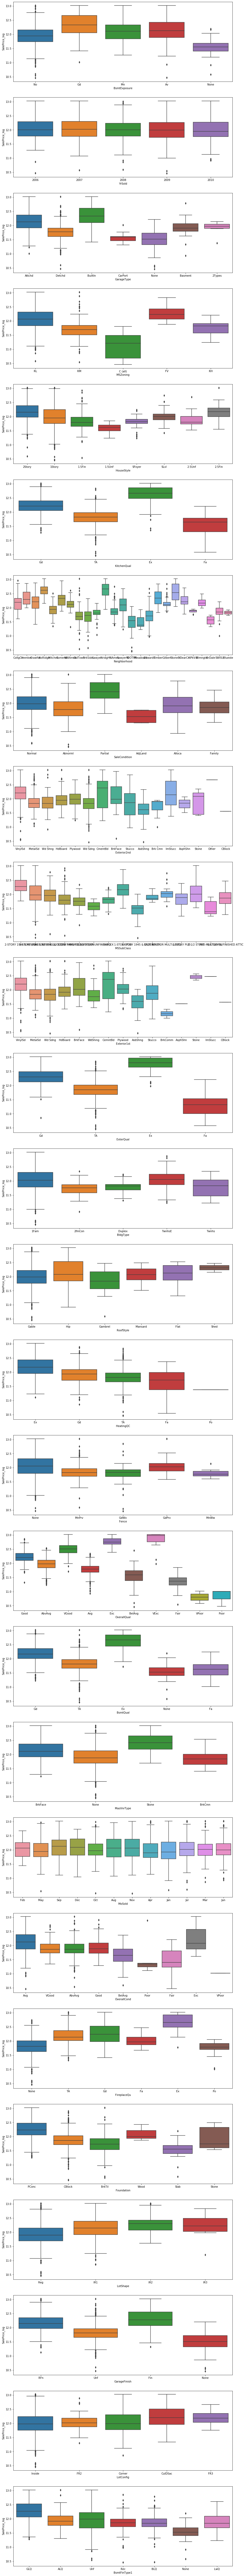

In [41]:
plt.figure(figsize=(15, 200))
for i in enumerate(cat_col):
    plt.subplot(30,1,i[0]+1)
    sns.boxplot(data=data, x=i[1], y='SalePrice_log')
plt.show()

#### Observations Categorical Variables
    OverallCond & OverallQuality & BasementQuality - Price is more for the one's Excellent followed by Good, Avg.
    HeatingQC - Price is more for the one's Excellent followed by Good, Avg.
    GarageFinish - Finished one's have more price.
    BsmntFinType1 - GoodQuality quarters have more price.
    MSZoning -'RL'(Residential Low Density), FV followed by 'RM'(Residential Medium Density).
    Foundation - Concrete houses are higher priced.

#### Separation of features for Label Encoding and One Hot Encoding

Label Encoding can be done for below columns

In [42]:
labelEncCol = [
'OverallQual',
'OverallCond',
'LotShape',
'ExterQual',
'BsmtQual',
'BsmtExposure',
'BsmtFinType1',
'HeatingQC',
'KitchenQual',
'FireplaceQu',
'GarageFinish']

### Creating Label Encoding

In [43]:
data['OverallQual'] = data['OverallQual'].map({'VPoor':0,'Poor':1,'Fair':2,'BelAvg':3,'Avg':4,'AbvAvg':5,'Good':6,'VGood':7,'Exc':8,'VExc':9})
data['OverallCond'] = data['OverallCond'].map({'VPoor':0,'Poor':1,'Fair':2,'BelAvg':3,'Avg':4,'AbvAvg':5,'Good':6,'VGood':7,'Exc':8,'VExc':9})

data['LotShape'] = data['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}) #3 indicates better i.e. Regular LotShape
data['ExterQual'] = data['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })

data['BsmtQual'] = data['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
data['BsmtExposure'] = data['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
data['BsmtFinType1'] = data['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
data['HeatingQC'] = data['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})

data['KitchenQual'] = data['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
data['FireplaceQu'] = data['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
data['GarageFinish'] = data['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 })

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        1460 non-null   object 
 1   MSZoning          1460 non-null   object 
 2   LotFrontage       1460 non-null   float64
 3   LotArea           1460 non-null   float64
 4   LotShape          1460 non-null   int64  
 5   LotConfig         1460 non-null   object 
 6   Neighborhood      1460 non-null   object 
 7   BldgType          1460 non-null   object 
 8   HouseStyle        1460 non-null   object 
 9   OverallQual       1460 non-null   int64  
 10  OverallCond       1460 non-null   int64  
 11  RoofStyle         1460 non-null   object 
 12  Exterior1st       1460 non-null   object 
 13  Exterior2nd       1460 non-null   object 
 14  MasVnrType        1460 non-null   object 
 15  MasVnrArea        1460 non-null   float64
 16  ExterQual         1460 non-null   int64  


One Hot Encoding can be done for below columns

In [45]:
dummy_col = list(set(cat_col)-set(labelEncCol))
dummy_col

['MoSold',
 'BldgType',
 'Foundation',
 'RoofStyle',
 'YrSold',
 'SaleCondition',
 'Neighborhood',
 'LotConfig',
 'Exterior2nd',
 'Fence',
 'GarageType',
 'MSZoning',
 'MSSubClass',
 'HouseStyle',
 'Exterior1st',
 'MasVnrType']

In [46]:
len(data.columns) == len(num_col) + len(dummy_col) + len(labelEncCol)

True

### One Hot Encoding Or Creating dummy variables

In [47]:
data = pd.get_dummies(data=data,columns=dummy_col,drop_first=True)

In [48]:
scaleCols = num_col+labelEncCol
scaleCols

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'Age_Built_Sold',
 'Age_ReBuilt_Sold',
 'Age_Garage_Sold',
 'SalePrice_log',
 'OverallQual',
 'OverallCond',
 'LotShape',
 'ExterQual',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish']

### Train Test Split

In [49]:
df_train, df_test = train_test_split(data, train_size=.7, random_state=100)

NameError: name 'train_test_split' is not defined

### Scaling of Data - MinMaxScaler

In [5661]:
scaler = MinMaxScaler()
df_train[scaleCols] = scaler.fit_transform(df_train[scaleCols])
df_test[scaleCols] = scaler.transform(df_test[scaleCols])

In [5662]:
y_train=df_train.pop('SalePrice_log')
X_train=df_train
y_test=df_test.pop('SalePrice_log')
X_test=df_test

### Custom Functions

In [5663]:
def PlotHistErrorTerms(y,y_pred):
    sns.set_style('white')
    plt.figure(figsize=(5,5), dpi=100)
    res1 = (y - y_pred)     #residuals
    sns.distplot(res1 , bins = 30, color='g')
    plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 18)               
    plt.xlabel('Errors', fontstyle='italic', fontsize = 12) 
    plt.grid(True)
    plt.show()

In [5664]:
def ScatterPlotActPred(y,y_pred):
    sns.set_style('white')
    plt.figure(figsize = (8,6))
    plt.scatter(y,y_pred)
    plt.title('y_actual vs y_pred', fontweight='bold', fontsize = 20)           
    plt.xlabel('y_actual', fontstyle='italic', fontsize = 16)              
    plt.ylabel('y_pred', fontstyle='italic', fontsize = 16) 
    plt.grid(True)
    plt.show()

In [5665]:
def PlotActualPredicted(y,y_pred,obsCount):
    sns.set_style('white')
    plt.figure(figsize = (8,4), dpi=120)
    f1 = [i for i in range(0,obsCount,1)]
    g1 = [i for i in range(0,obsCount,1)]
    plt.plot(f1, y_pred, color="blue", linewidth=1, linestyle="-")     
    plt.plot(g1, y, color="red",  linewidth=1, linestyle="-")  
    plt.title("Actual and Predicted", fontsize=15, fontweight='bold')    
    plt.xlabel('Index', fontsize=15, fontstyle='italic')                              
    plt.ylabel('SalePrice', fontsize=15, fontstyle='italic')  
    plt.show()

In [5666]:
def PlotErroTermSpread(y,y_pred,obsCount):
    sns.set_style('white')
    plt.figure(figsize = (6,4), dpi=100)
    j1 = [i for i in range(0,obsCount,1)] 
    res_train1 = (y_train-y_pred_train_l)
    plt.scatter(j1, res_train1)

    plt.title('Error Terms', fontsize=18, fontweight='bold')              
    plt.xlabel('Index', fontstyle='italic', fontsize=14)                      
    plt.ylabel('y_actual - y_pred', fontstyle='italic', fontsize=14)   
    plt.grid(True)
    plt.show()

In [5667]:
def predictions(y,y_pred):
    ##R2 score
    r2score = round(r2_score(y_true= y, y_pred= y_pred),4)
    
    ##Check the mean squared error (MSE)
    MSE = round(mean_squared_error(y, y_pred),4)
    
    ##Mean Absolute error for train and test sets
    MAE = round(mean_absolute_error(y, y_pred),4)

    ##Root Mean Squared Error for Train and Test Sets
    RMSE = round(np.sqrt(MAE),4)
    print("\nR2 score:",r2score,"\nMSE score:",MSE,"\nMAE score:",MAE,"\nRMSE score:",RMSE)



In [5668]:
def createDataFrameModelCoeff(coef):
    df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':coef.round(4), \
                         'Abs_Coefficient(Desc_Sort)':abs(coef.round(4))})
    ##Sorting coefficient in descending order of absolute values and reset index
    df = df.sort_values(by='Abs_Coefficient(Desc_Sort)', ascending=False)
    df.reset_index(drop=True, inplace=True)  
    return df

In [5669]:
def PlotCoeffTop10(df):
    top10_df= df.loc[:9] #Lasso_df with top 10 coefficients

    sns.set(style='white')
    plt.figure(figsize=(16,8), dpi=120)
    ax4= sns.barplot(y=top10_df['Features'], x=top10_df['Coefficient'], palette='Set1')

    plt.xlabel('Coefficient Values', fontsize= 14, fontstyle='italic')
    plt.ylabel('Features' , fontsize= 14, fontstyle='italic')
    plt.title('Coefficents of Top 10 Features : ', fontsize=18,fontweight='bold')

    c= top10_df['Coefficient'] #Storing coefficient values
    for index, value in enumerate(c):
        plt.text(value, index, str(value), fontsize=13)

    plt.grid(True)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.autoscale()
    plt.tight_layout()
    plt.show() 

### Lasso Regression Model

In [5670]:
folds = 5
lasso = Lasso()

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    3.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [5671]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [5672]:
#Fitting Ridge model for best alpha and printing coefficients which have been penalised

alpha_lasso1 =0.0001

lasso1 = Lasso(alpha=alpha_lasso1)
        
lasso1.fit(X_train, y_train) 

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [5673]:
y_pred_train_lasso1 = lasso1.predict(X_train)
y_pred_test_lasso1 = lasso1.predict(X_test)

In [5674]:
print("For Lasso Regression Model (Original Model: alpha=" + str(alpha_lasso1) +"):\n","*"*55)
print("\nFor Train Set:")
predictions(y_train,y_pred_train_lasso1)
print("\nFor Test Set:")
predictions(y_test,y_pred_test_lasso1)

For Lasso Regression Model (Original Model: alpha=0.0001):
 *******************************************************

For Train Set:

R2 score: 0.9304 
MSE score: 0.0016 
MAE score: 0.0281 
RMSE score: 0.1676

For Test Set:

R2 score: 0.8929 
MSE score: 0.0026 
MAE score: 0.0337 
RMSE score: 0.1836


In [5675]:
print("Number of non-zero Coefficients for Original Lasso model {}".format(np.sum(lasso1.coef_!=0)))

Number of non-zero Coefficients for Original Lasso model 97


In [5676]:
lasso1_df = createDataFrameModelCoeff(lasso1.coef_)
lasso1_df.head(10)

,Features,Coefficient,Abs_Coefficient(Desc_Sort)
0,GrLivArea,0.2352,0.2352
1,OverallQual,0.1544,0.1544
2,OverallCond,0.1275,0.1275
3,MSZoning_FV,0.0811,0.0811
4,TotalBsmtSF,0.0807,0.0807
5,Age_Built_Sold,-0.0778,0.0778
6,MSZoning_RL,0.0777,0.0777
7,MSZoning_RH,0.0753,0.0753
8,MSZoning_RM,0.0590,0.0590
9,LotArea,0.0456,0.0456


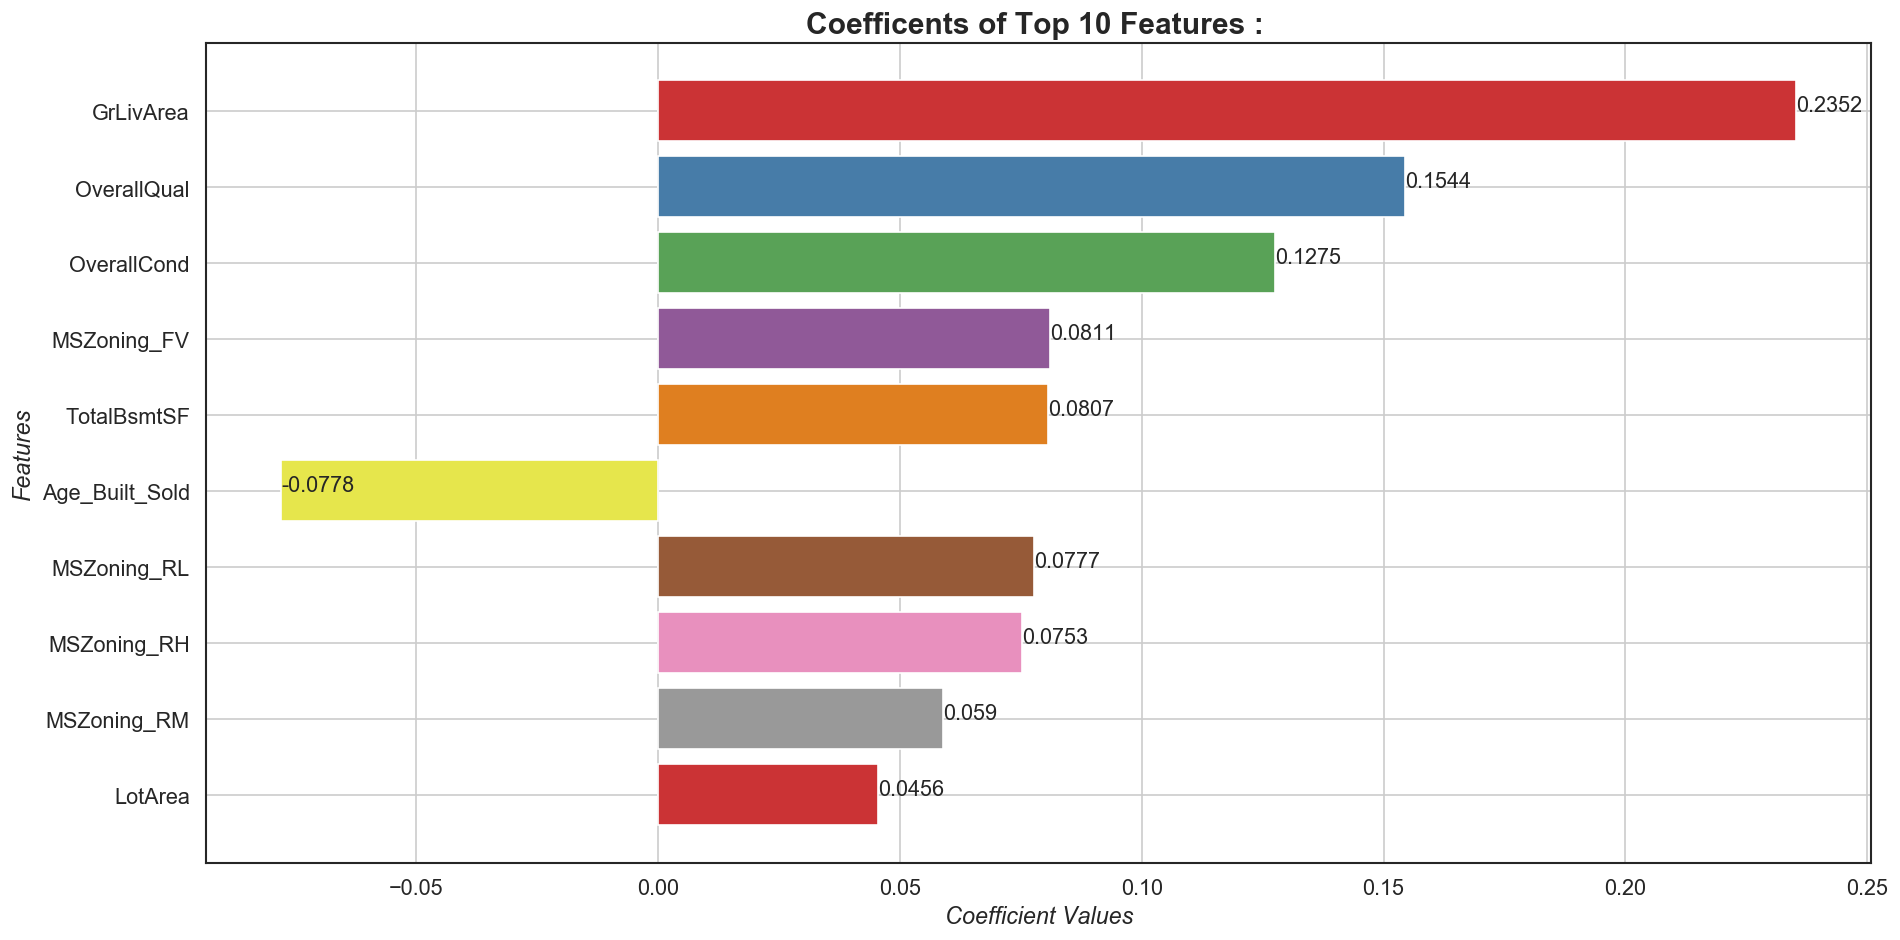

In [5677]:
PlotCoeffTop10(lasso1_df)

#### Check Assumptions for Lasso model

#### Training Set

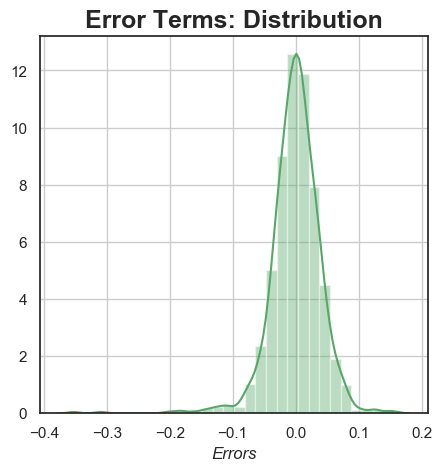

In [5678]:
PlotHistErrorTerms(y_train,y_pred_train_lasso1)

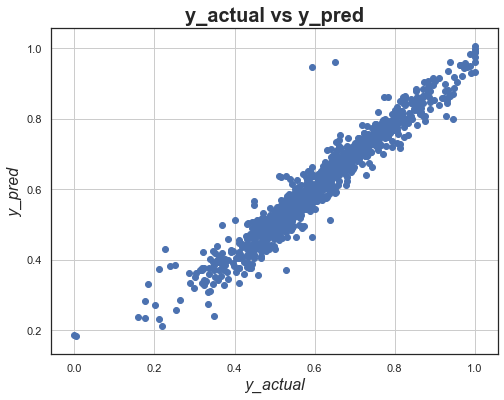

In [5679]:
ScatterPlotActPred(y_train,y_pred_train_lasso1)

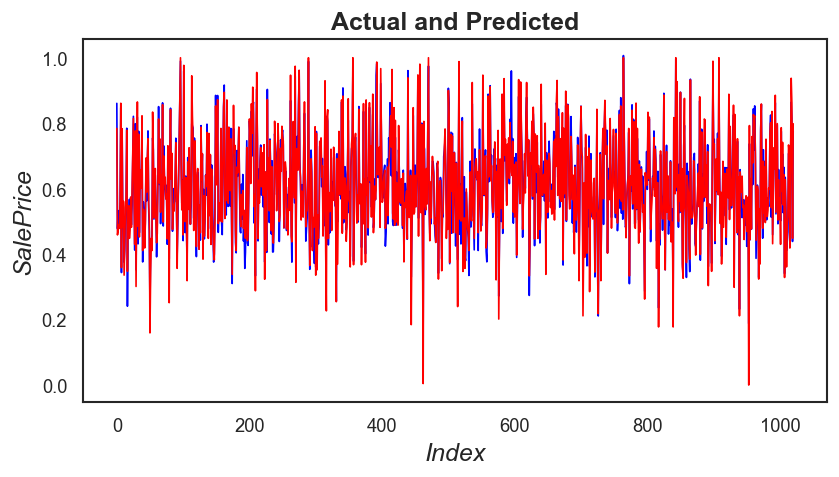

In [5680]:
PlotActualPredicted(y_train,y_pred_train_lasso1,1021)

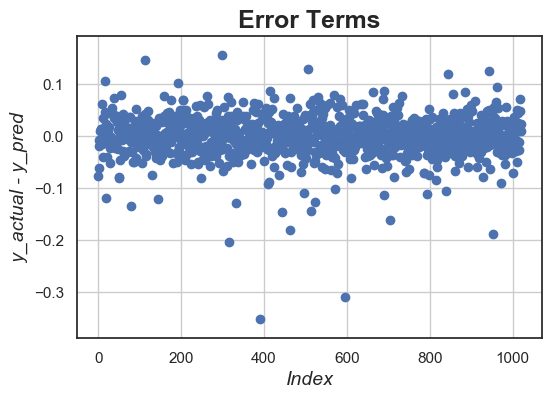

In [5681]:
PlotErroTermSpread(y_train,y_pred_train_lasso1,1021)

#### Test Set

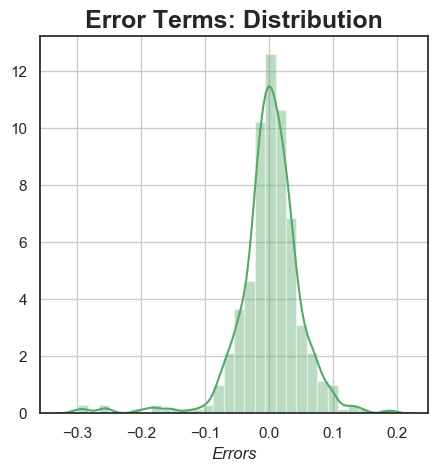

In [5682]:
PlotHistErrorTerms(y_test,y_pred_test_lasso1)

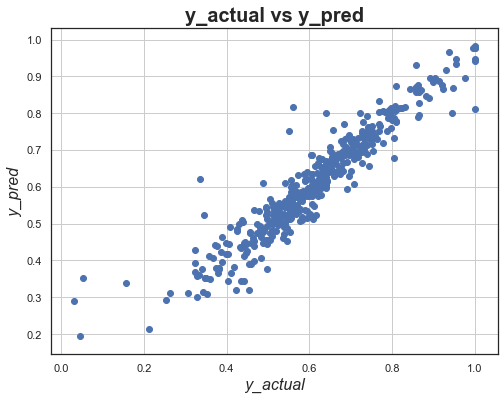

In [5683]:
ScatterPlotActPred(y_test,y_pred_test_lasso1)

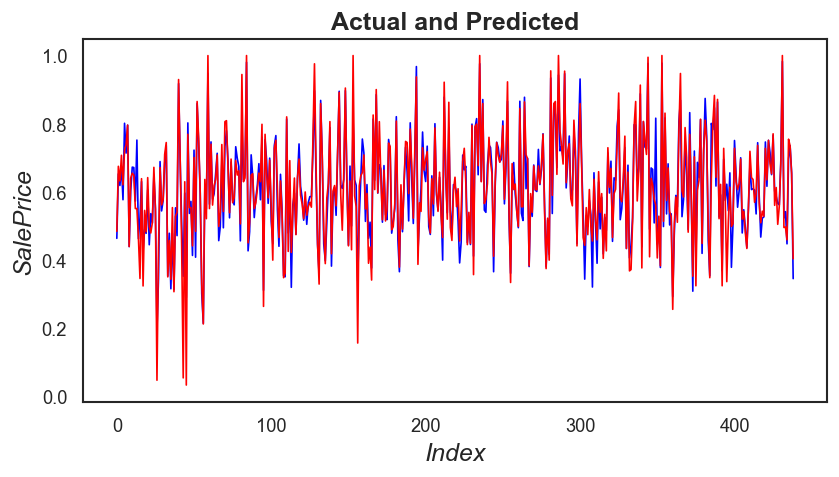

In [5684]:
PlotActualPredicted(y_test,y_pred_test_lasso1,439)

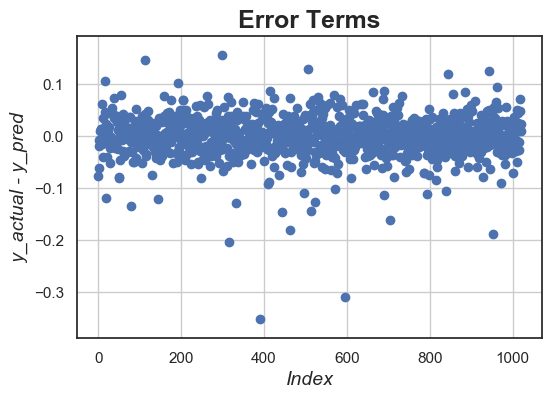

In [5685]:
PlotErroTermSpread(y_test,y_pred_test_lasso1,1021)

#### Assumptions has been validated and they hold good.
    Error terms are normally distributed
    There is no pattern found in the error distribution
    There is homoscedasticity in the error terms

### Ridge Regression

In [5686]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [5687]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 1.0}


In [5688]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha_ridge1 = 1.0
ridge1 = Ridge(alpha=alpha_ridge1)

ridge1.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [5689]:
y_pred_train_ridge1 = ridge1.predict(X_train)
y_pred_test_ridge1 = ridge1.predict(X_test)

In [5690]:
print("For Ridge Regression Model (Original Model: alpha=" + str(alpha_ridge1) +"):\n","*"*55)
print("\nFor Train Set:")
predictions(y_train,y_pred_train_ridge1)
print("\nFor Test Set:")
predictions(y_test,y_pred_test_ridge1)

For Ridge Regression Model (Original Model: alpha=1.0):
 *******************************************************

For Train Set:

R2 score: 0.9334 
MSE score: 0.0016 
MAE score: 0.0276 
RMSE score: 0.1661

For Test Set:

R2 score: 0.888 
MSE score: 0.0027 
MAE score: 0.0346 
RMSE score: 0.186


In [5691]:
ridge1_df = createDataFrameModelCoeff(ridge1.coef_)
ridge1_df.head(10)

,Features,Coefficient,Abs_Coefficient(Desc_Sort)
0,GrLivArea,0.1710,0.1710
1,OverallQual,0.1279,0.1279
2,OverallCond,0.1177,0.1177
3,MSZoning_FV,0.0880,0.0880
4,MSZoning_RH,0.0875,0.0875
5,TotalBsmtSF,0.0874,0.0874
6,MSZoning_RL,0.0839,0.0839
7,MSZoning_RM,0.0719,0.0719
8,Age_Built_Sold,-0.0646,0.0646
9,Neighborhood_StoneBr,0.0531,0.0531


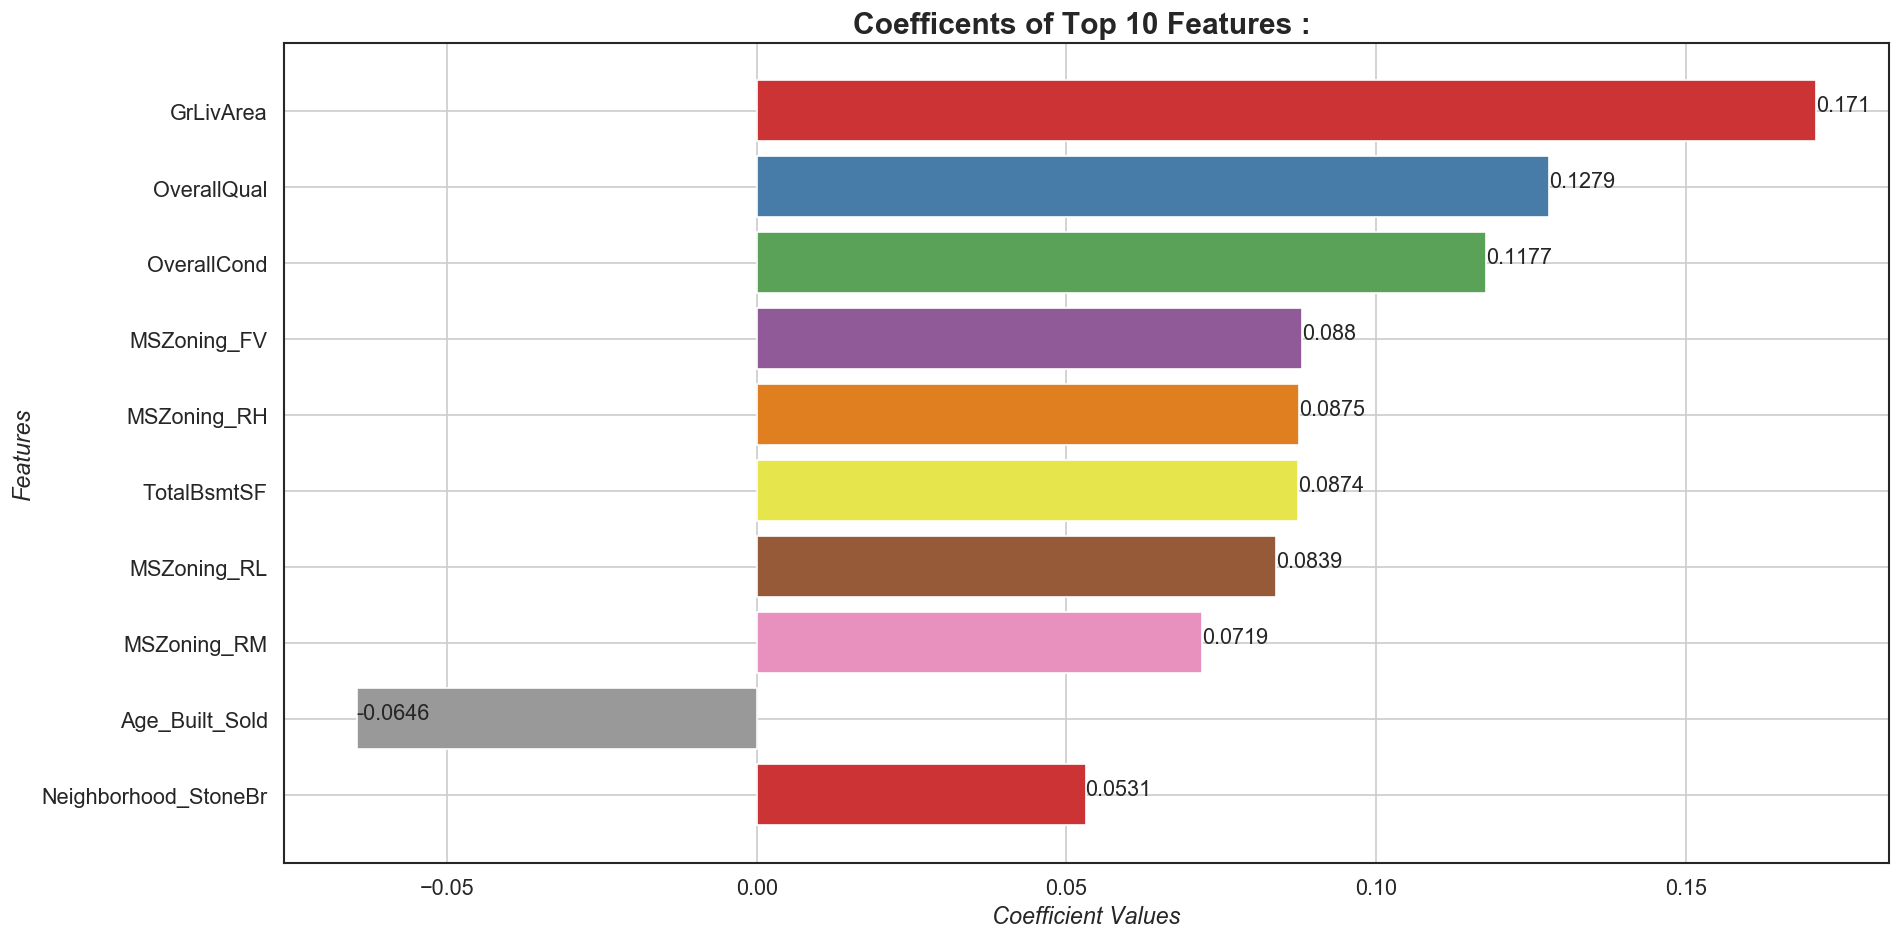

In [5692]:
PlotCoeffTop10(ridge1_df)

In [5693]:
betas = pd.DataFrame({'Features':X_train.columns,'Ridge':ridge1.coef_,'Abs_Coefficient_Ridge':abs(ridge1.coef_.round(4)),'Lasso':lasso1.coef_,'Abs_Coefficient_Lasso':abs(lasso1.coef_.round(4))})
betas.set_index('Features',inplace = True)
betas.sort_values(by='Abs_Coefficient_Lasso', ascending=False,inplace=True)
betas.head(10)

,Ridge,Abs_Coefficient_Ridge,Lasso,Abs_Coefficient_Lasso
Features,,,,
GrLivArea,0.170981,0.1710,0.235203,0.2352
OverallQual,0.127932,0.1279,0.154440,0.1544
OverallCond,0.117749,0.1177,0.127520,0.1275
MSZoning_FV,0.087956,0.0880,0.081057,0.0811
TotalBsmtSF,0.087403,0.0874,0.080748,0.0807
Age_Built_Sold,-0.064575,0.0646,-0.077809,0.0778
MSZoning_RL,0.083913,0.0839,0.077680,0.0777
MSZoning_RH,0.087513,0.0875,0.075344,0.0753
MSZoning_RM,0.071852,0.0719,0.058971,0.0590


#### Model Selection
The test accuracy is better for Lasso and in return the error is less. Also, the train test accuracy difference is less for Lasso.
Lasso helps in feature selection as the non important features coefficients are 0.
Due to above reasons I would select the Lasso model.


### Inference

The top 10 predictors for the house prices are : 

    GrLivArea - Price increases as the area of living area above ground is more.	
    OverallQual	- Price is more for houses with excellent OverallQual.
    OverallCond	- Price is more for houses with excellent OverallCond.
    MSZoningFV, MSZoning_RL, MSZoning_RH, MSZoning_RM - Prices are also dependend on zone of the house - Resedential one's.
    TotalBsmtSF	- Price increases for houses having higher basement area.
    Age_Built_Sold - Prices are less for older houses.
    LotArea - Houses with higher lot areas also have higher price.


### Subjective Question 1 - Alpha is Doubled

#### Alpha is doubled for Lasso from 0.0001 to 0.0002

In [5694]:
alpha_lasso2 =0.0002

lasso2 = Lasso(alpha=alpha_lasso2)
        
lasso2.fit(X_train, y_train) 

Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [5695]:
y_pred_train_lasso2 = lasso2.predict(X_train)
y_pred_test_lasso2 = lasso2.predict(X_test)

In [5696]:
print("For Lasso Regression Model (Doubled Alpha Model: alpha=" + str(alpha_lasso2) +"):\n","*"*55)
print("\nFor Train Set:")
predictions(y_train,y_pred_train_lasso2)
print("\nFor Test Set:")
predictions(y_test,y_pred_test_lasso2)

For Lasso Regression Model (Doubled Alpha Model: alpha=0.0002):
 *******************************************************

For Train Set:

R2 score: 0.9244 
MSE score: 0.0018 
MAE score: 0.029 
RMSE score: 0.1703

For Test Set:

R2 score: 0.8909 
MSE score: 0.0027 
MAE score: 0.0339 
RMSE score: 0.1841


In [5697]:
print("Number of non-zero Coefficients for Doubled Alpha Lasso model {}".format(np.sum(lasso2.coef_!=0)))

Number of non-zero Coefficients for Doubled Alpha Lasso model 77


In [5698]:
lasso2_df = createDataFrameModelCoeff(lasso2.coef_)
lasso2_df.head(10)

,Features,Coefficient,Abs_Coefficient(Desc_Sort)
0,GrLivArea,0.2366,0.2366
1,OverallQual,0.1668,0.1668
2,OverallCond,0.1251,0.1251
3,Age_Built_Sold,-0.0766,0.0766
4,TotalBsmtSF,0.0720,0.0720
5,LotArea,0.0424,0.0424
6,Neighborhood_Crawfor,0.0415,0.0415
7,GarageCars,0.0388,0.0388
8,Neighborhood_Somerst,0.0340,0.0340
9,Neighborhood_NridgHt,0.0337,0.0337


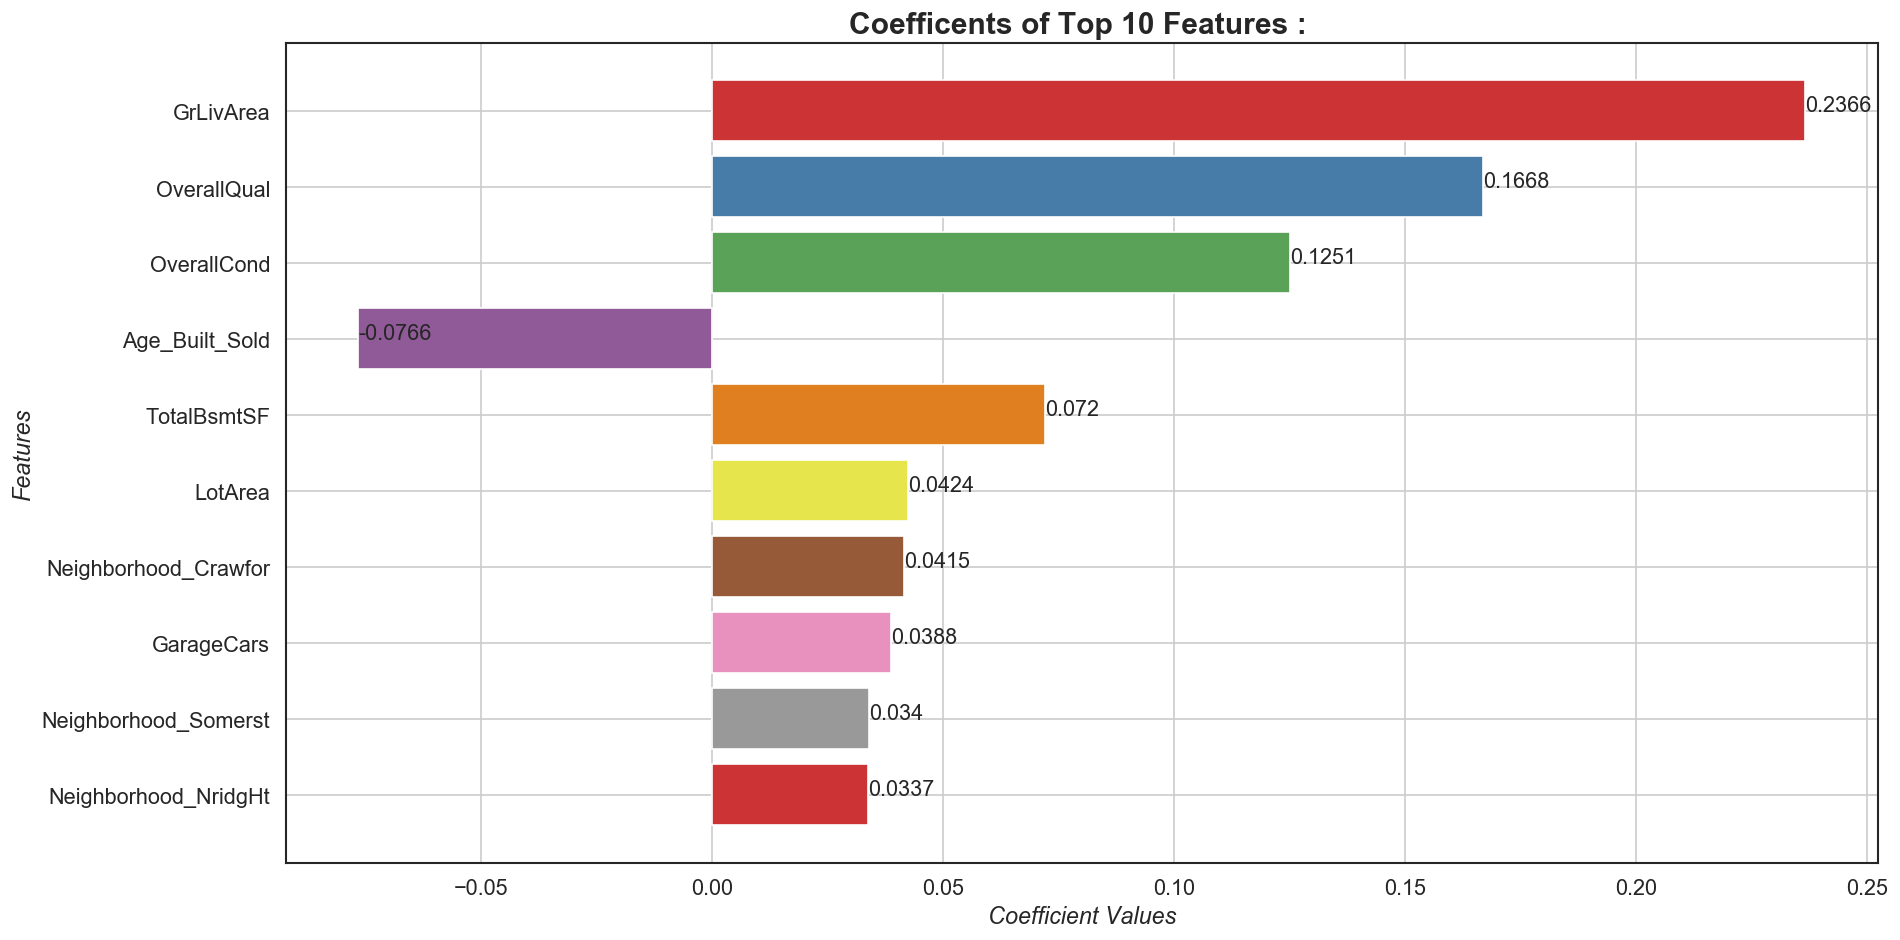

In [5699]:
PlotCoeffTop10(lasso2_df)

In [5700]:
top10_lasso2_features = list(lasso2_df['Features'].iloc[0:10])
top10_lasso2_features

['GrLivArea',
 'OverallQual',
 'OverallCond',
 'Age_Built_Sold',
 'TotalBsmtSF',
 'LotArea',
 'Neighborhood_Crawfor',
 'GarageCars',
 'Neighborhood_Somerst',
 'Neighborhood_NridgHt']

#### Alpha is doubled for Ridge from 1.0 to 2.0

In [5701]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha_ridge2 = 2.0
ridge2 = Ridge(alpha=alpha_ridge2)

ridge2.fit(X_train, y_train)

Ridge(alpha=2.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [5702]:
y_pred_train_ridge2 = ridge2.predict(X_train)
y_pred_test_ridge2 = ridge2.predict(X_test)

In [5703]:
print("For Ridge Regression Model (Doubled Alpha Model: alpha=" + str(alpha_ridge2) +"):\n","*"*55)
print("\nFor Train Set:")
predictions(y_train,y_pred_train_ridge2)
print("\nFor Test Set:")
predictions(y_test,y_pred_test_ridge2)

For Ridge Regression Model (Doubled Alpha Model: alpha=2.0):
 *******************************************************

For Train Set:

R2 score: 0.9312 
MSE score: 0.0016 
MAE score: 0.0279 
RMSE score: 0.167

For Test Set:

R2 score: 0.8869 
MSE score: 0.0028 
MAE score: 0.0347 
RMSE score: 0.1863


In [5704]:
ridge2_df = createDataFrameModelCoeff(ridge2.coef_)
ridge2_df.head(10)

,Features,Coefficient,Abs_Coefficient(Desc_Sort)
0,GrLivArea,0.1385,0.1385
1,OverallQual,0.1202,0.1202
2,OverallCond,0.1083,0.1083
3,TotalBsmtSF,0.0776,0.0776
4,MSZoning_FV,0.0630,0.0630
5,MSZoning_RL,0.0607,0.0607
6,MSZoning_RH,0.0602,0.0602
7,Age_Built_Sold,-0.0571,0.0571
8,1stFlrSF,0.0515,0.0515
9,Neighborhood_StoneBr,0.0494,0.0494


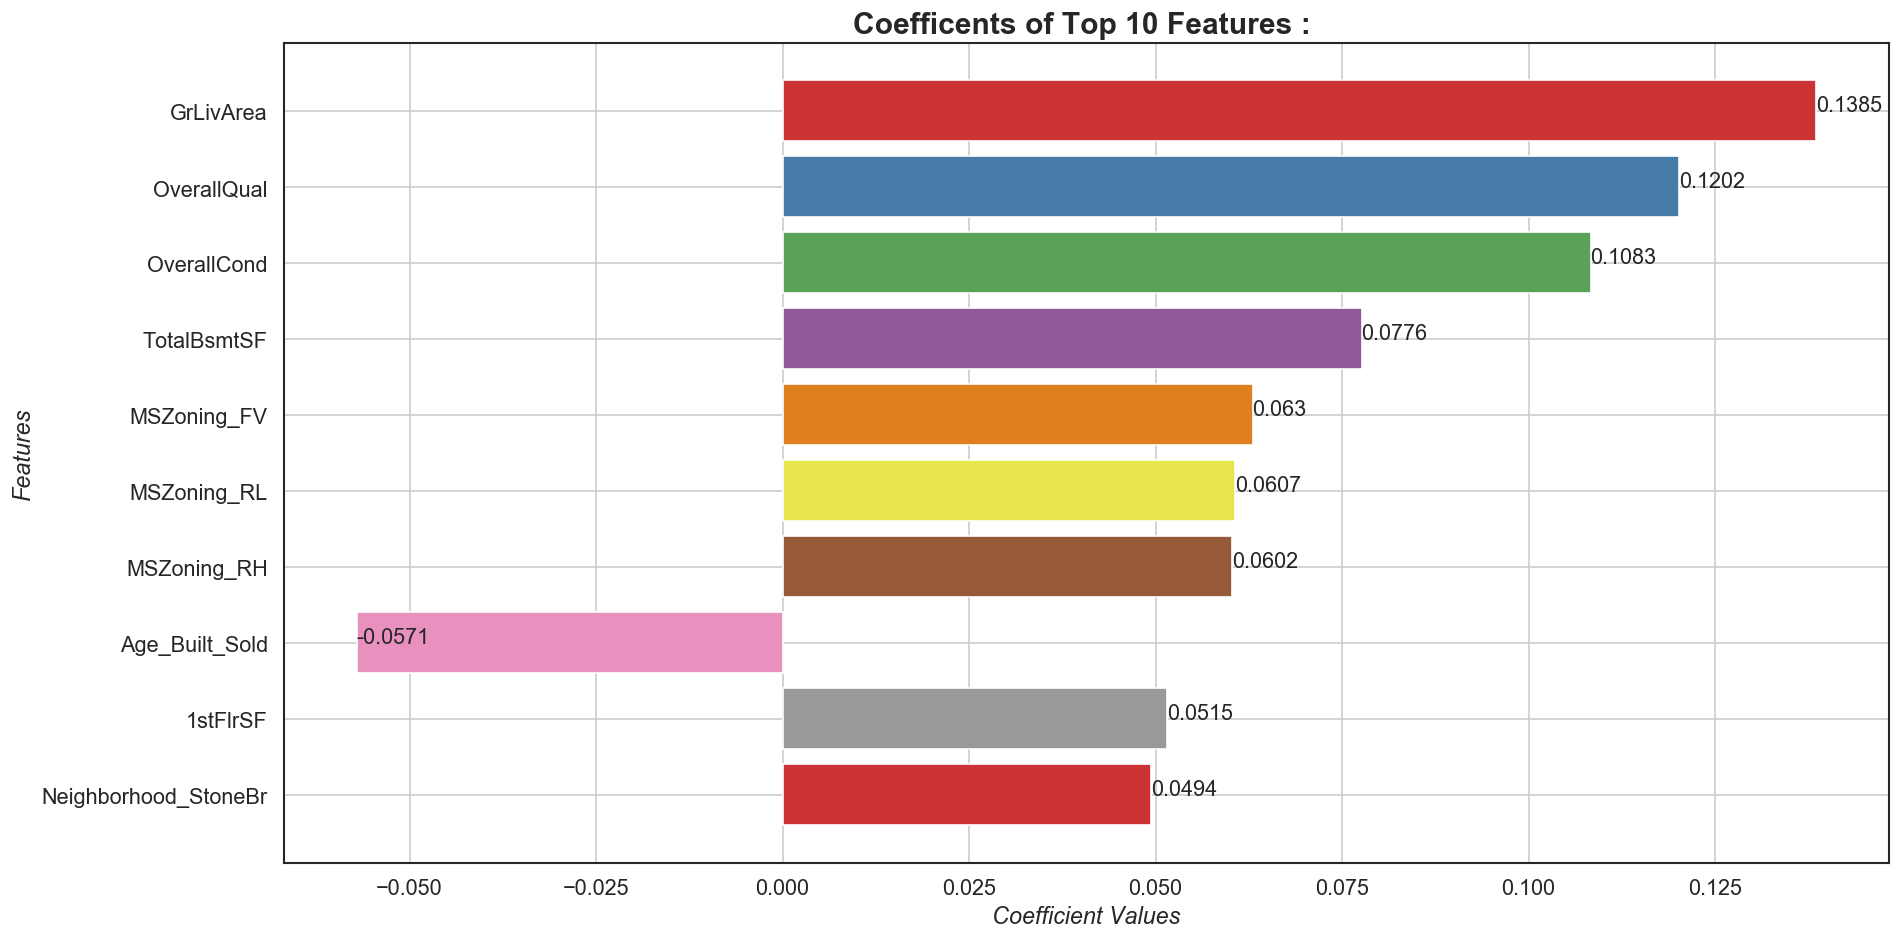

In [5705]:
PlotCoeffTop10(ridge2_df)

In [5706]:
top10_ridge2_features = list(ridge2_df['Features'].iloc[0:10])
top10_ridge2_features

['GrLivArea',
 'OverallQual',
 'OverallCond',
 'TotalBsmtSF',
 'MSZoning_FV',
 'MSZoning_RL',
 'MSZoning_RH',
 'Age_Built_Sold',
 '1stFlrSF',
 'Neighborhood_StoneBr']

### Subjective Question 3

#### Top 5 features are removed from Lasso model and the model is rebuilt.

In [5707]:
top5_lasso1_features = list(lasso1_df['Features'].iloc[0:5])
top5_lasso1_features

['GrLivArea', 'OverallQual', 'OverallCond', 'MSZoning_FV', 'TotalBsmtSF']

In [5708]:
X_train = X_train.drop(top5_lasso1_features,axis=1)
X_test = X_test.drop(top5_lasso1_features,axis=1)

In [5709]:
lasso = Lasso()

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [5710]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [5711]:
alpha_lasso3 =0.0001

lasso3 = Lasso(alpha=alpha_lasso3)
        
lasso3.fit(X_train, y_train) 

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [5712]:
y_pred_train_lasso3 = lasso3.predict(X_train)
y_pred_test_lasso3 = lasso3.predict(X_test)

In [5713]:
print("For Lasso Regression Model (Removed top 5 Features Model: alpha=" + str(alpha_lasso3) +"):\n","*"*55)
print("\nFor Train Set:")
predictions(y_train,y_pred_train_lasso3)
print("\nFor Test Set:")
predictions(y_test,y_pred_test_lasso3)

For Lasso Regression Model (Removed top 5 Features Model: alpha=0.0001):
 *******************************************************

For Train Set:

R2 score: 0.9111 
MSE score: 0.0021 
MAE score: 0.0322 
RMSE score: 0.1794

For Test Set:

R2 score: 0.8593 
MSE score: 0.0034 
MAE score: 0.0396 
RMSE score: 0.199


In [5714]:
print("Number of non-zero Coefficients for Lasso model after removing top 5 features {}".format(np.sum(lasso3.coef_!=0)))

Number of non-zero Coefficients for Lasso model after removing top 5 features 109


In [5715]:
lasso3_df = createDataFrameModelCoeff(lasso3.coef_)
lasso3_df.head(10)

,Features,Coefficient,Abs_Coefficient(Desc_Sort)
0,1stFlrSF,0.1948,0.1948
1,2ndFlrSF,0.1341,0.1341
2,Neighborhood_Somerst,0.0687,0.0687
3,Exterior1st_BrkComm,-0.0680,0.0680
4,Neighborhood_MeadowV,-0.0667,0.0667
5,Neighborhood_StoneBr,0.0659,0.0659
6,BsmtQual,0.0575,0.0575
7,Neighborhood_Crawfor,0.0509,0.0509
8,Age_ReBuilt_Sold,-0.0506,0.0506
9,Neighborhood_NridgHt,0.0493,0.0493


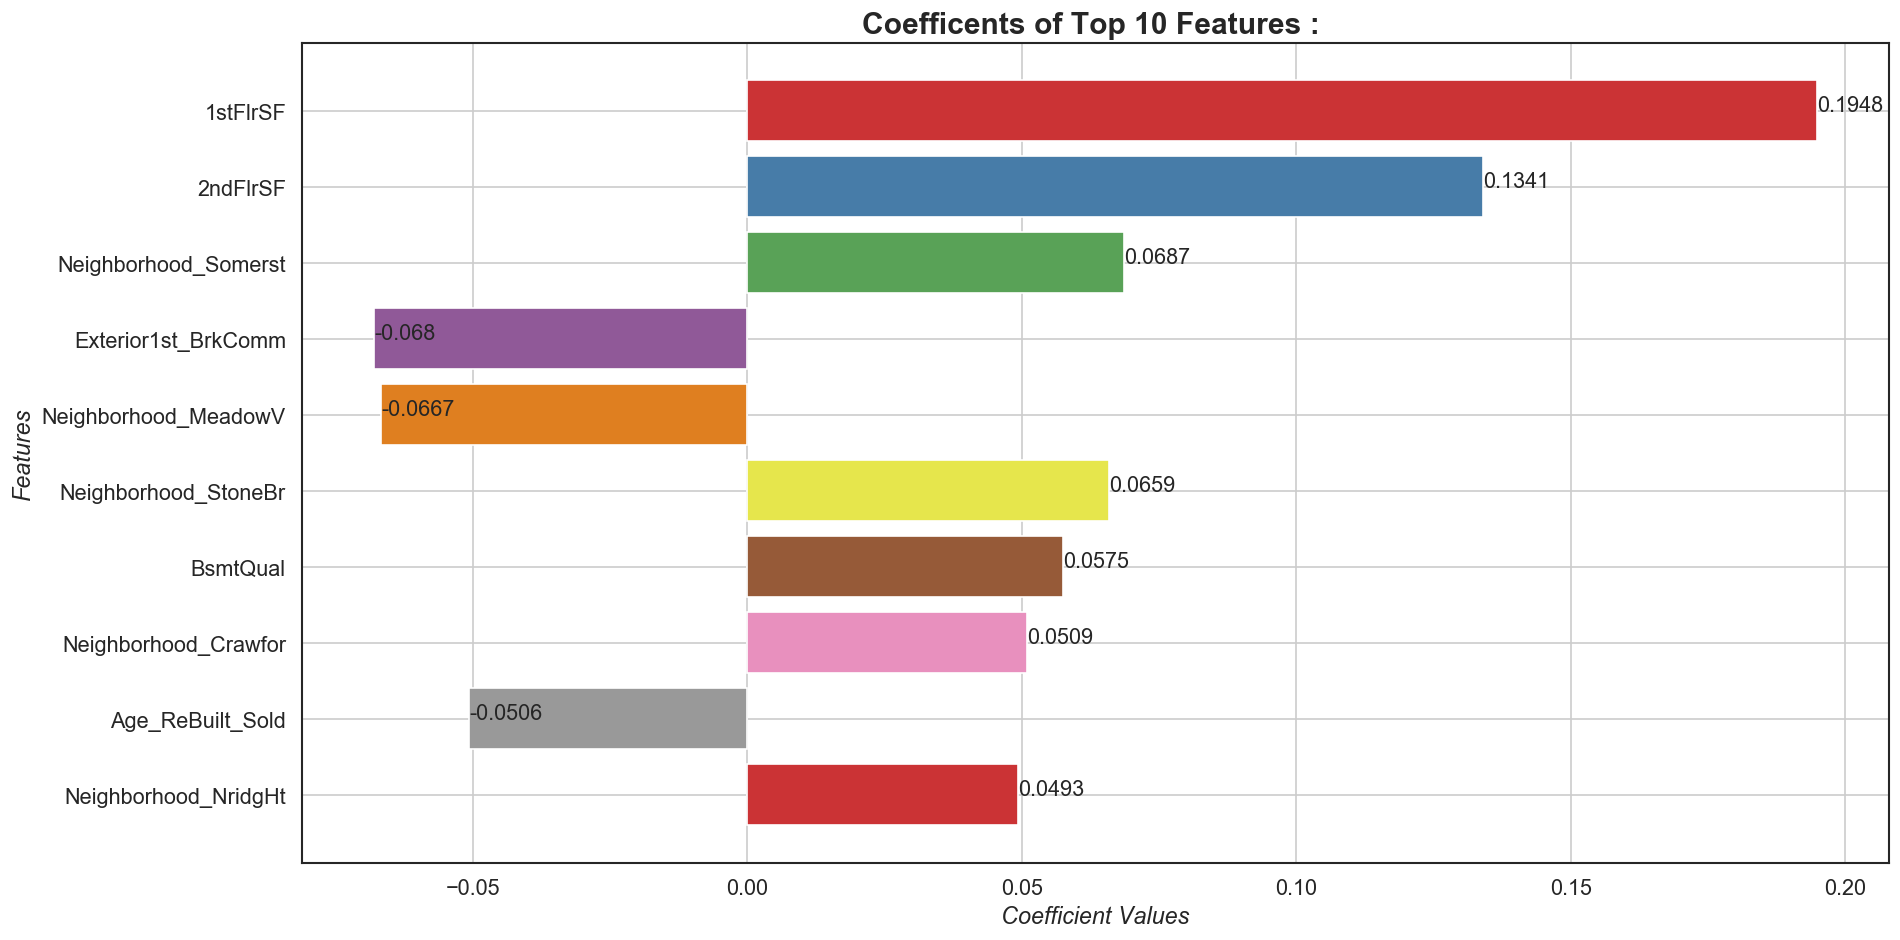

In [5716]:
PlotCoeffTop10(lasso3_df)

In [5717]:
top5_lasso3_features = list(lasso3_df['Features'].iloc[0:5])
top5_lasso3_features

['1stFlrSF',
 '2ndFlrSF',
 'Neighborhood_Somerst',
 'Exterior1st_BrkComm',
 'Neighborhood_MeadowV']